In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
while os.path.split(os.getcwd())[1].lower() != "deuce-deep-probabilistic-nowcasting":
    os.chdir("..")

from pathlib import Path

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from datamodules import FMICompositeDataModule
from utils import load_config

/home/users/harnist/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
cfg_path = "config/data_distribution/"
data_name = "fmi"
platform = "athras"
SAVEFIG = False

platform_cfg = load_config(cfg_path / Path(f"{data_name}_platform.yaml"))
data_cfg = load_config(cfg_path / Path(f"{data_name}_dataset.yaml"))
data_cfg.update(platform_cfg)

plt.style.use("bmh")

In [38]:
dm = FMICompositeDataModule(data_cfg)
dm.setup(stage="fit")

In [39]:
n_bins = 91
rng = (-31,60)
hists = {}
splits = ["train", "valid", "test"]

In [40]:
TITLES = {
    "train": "(a) Training data set",
    "valid": "(b) Validation data set",
    "test": "(c) verification data set",
}

In [41]:
hist = None
bins = None
count = 0
n = 0

for i, batch in enumerate(tqdm(dm.test_dataloader())):
    h_, bins = np.histogram(
                batch["inputs"][:, -1, :, :].numpy().ravel(), bins=n_bins, range=rng
            )
    count += sum(h_)
    if hist is None:
        hist = h_
    else:
        hist += h_

hists["test"] = {
            "hist": hist,
            "count": count,
        }


  0%|          | 0/306 [00:00<?, ?it/s]

/home/users/harnist/deuce-deep-probabilistic-nowcasting/datasets/fmi_dataset.py:155: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  return self.windows.iloc[ds_index].dt.to_pydatetime()
/home/users/harnist/deuce-deep-probabilistic-nowcasting/datasets/fmi_dataset.py:155: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  return self.windows.iloc[ds_index].dt.to_pydatetime()
/home/users/harnist/deuce-deep-probabilistic-nowcasting/datasets/fmi_dataset.py:155: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime

In [43]:

hist = None
bins = None
count = 0
n = 0

for i, batch in enumerate(tqdm(dm.train_dataloader())):
    h_, bins = np.histogram(
                batch["inputs"][:, -1, :, :].numpy().ravel(), bins=n_bins, range=rng
            )
    count += sum(h_)
    if hist is None:
        hist = h_
    else:
        hist += h_

hists["train"] = {
            "hist": hist,
            "count": count,
        }

hist = None
bins = None
count = 0
n = 0

for i, batch in enumerate(tqdm(dm.val_dataloader())):
    h_, bins = np.histogram(
                batch["inputs"][:, -1, :, :].numpy().ravel(), bins=n_bins, range=rng
            )
    count += sum(h_)
    if hist is None:
        hist = h_
    else:
        hist += h_

hists["valid"] = {
            "hist": hist,
            "count": count,
        }


  0%|          | 0/1980 [00:00<?, ?it/s]/home/users/harnist/deuce-deep-probabilistic-nowcasting/datasets/fmi_dataset.py:155: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  return self.windows.iloc[ds_index].dt.to_pydatetime()
/home/users/harnist/deuce-deep-probabilistic-nowcasting/datasets/fmi_dataset.py:155: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  return self.windows.iloc[ds_index].dt.to_pydatetime()
/home/users/harnist/deuce-deep-probabilistic-nowcasting/datasets/fmi_dataset.py:155: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will re

In [44]:
%matplotlib inline

In [45]:
hists["all"] = {
    "hist" : sum([hists[split]["hist"] for split in splits]),
    "count" : sum([hists[split]["count"] for split in splits]),
}

In [46]:
hists["all"]["density"] = hists["all"]["hist"] / hists["all"]["count"]

In [47]:
hists["all"]["count"]

1750325336

In [48]:
a = hists["all"]["density"][40:].max()
a

0.021867944897302222

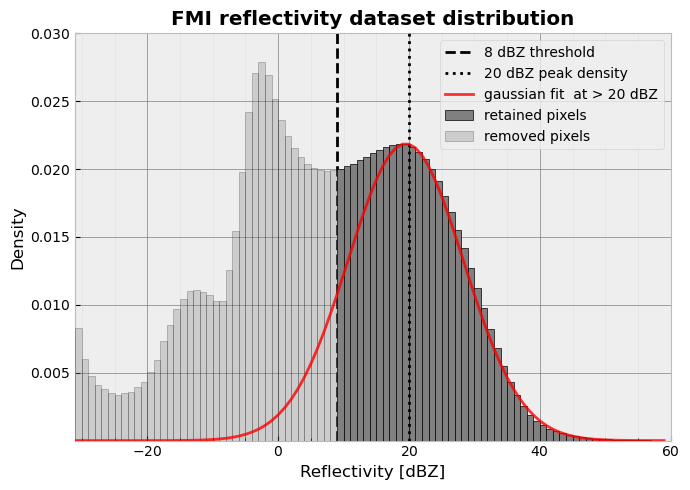

In [49]:
_, bins = np.histogram([], bins=n_bins, range=rng)

ncols = 1
nrows = 1
fig, ax = plt.subplots(
    figsize=(7*ncols, 5),
    nrows=nrows,
    ncols=ncols,
    squeeze=True,
    sharex="row",
)

width = bins[-1] - bins[-2]

ax.set_title("FMI reflectivity dataset distribution", fontweight="semibold")

ax.bar(
        bins[40:-1],
        hists["all"]["density"][40:],
        width=width,
        align="edge",
        color="gray",
        edgecolor="k",
        zorder=10,
        label="retained pixels"
    )
ax.bar(
        bins[:40],
        hists["all"]["density"][:40],
        width=width,
        align="edge",
        color="gray",
        edgecolor="k",
        zorder=10,
        alpha=0.3,
        label = "removed pixels"
    )
ax.vlines(x=[9.0], ymin=0, ymax=0.04, colors="k", linestyles="dashed", linewidth=2, label="8 dBZ threshold")
ax.vlines(x=[bins[51]], ymin=0, ymax=0.04, colors="k", linestyles="dotted", linewidth=2, label=f"{int(bins[51])} dBZ peak density", zorder=14)

def gaus(x, a, x0, sigma):
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

from scipy.optimize import curve_fit

x_to_fit = np.arange(bins[51]-len(bins[51:-1]),bins[51]+len(bins[51:-1]) )
y_to_fit = np.concatenate([hists["all"]["density"][51:][::-1],hists["all"]["density"][51:]])


popt, pcov = curve_fit(gaus, x_to_fit, y_to_fit, p0=(0.01,20,10), bounds=[[0.01,10,5],[0.05,30,15]])
x_to_plot_fit = np.arange(-32, 60, 1)
curve = gaus(x_to_plot_fit, *popt)
ax.plot(x_to_plot_fit, curve, color='r', zorder=15, label=f"gaussian fit  at > {int(bins[51])} dBZ", alpha=0.8)


ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0))
ax.set_ylim(bottom=0, top=0.03)
ax.set_xlim(rng)
ax.grid(which="major", lw=0.5, color="tab:gray", ls="-", zorder=0)
ax.grid(which="minor", lw=0.5, color="tab:gray", ls="-", alpha=0.1, zorder=0)

ax.set_yscale("linear")
ax.legend()
ax.set_ylabel("Density")
ax.set_xlabel("Reflectivity [dBZ]")

fig.tight_layout()
fig.show()

In [55]:
if SAVEFIG: 
    fig.savefig("data/figures/explaining_distribution.pdf")

In [51]:
bins

array([-31., -30., -29., -28., -27., -26., -25., -24., -23., -22., -21.,
       -20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
         2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.])